In [1]:
import os

In [2]:
os.environ['OMP_NUM_THREADS']='1'

In [3]:
import gym, ray

from time import sleep
from pong import keep_ids

In [4]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [5]:
ray.init(object_store_memory=int(0.5*2**30), redis_max_memory=int(0.5*2**30))

2019-02-21 11:27:10,806	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-21_11-27-10_24057/logs.
2019-02-21 11:27:10,912	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:14919 to respond...
2019-02-21 11:27:11,043	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:42015 to respond...
2019-02-21 11:27:11,049	INFO services.py:798 -- Starting Redis shard with 0.54 GB max memory.
2019-02-21 11:27:11,089	INFO services.py:1360 -- Starting the Plasma object store with 0.5368709119999999 GB memory using /dev/shm.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=1ca7027467edd901c37de5fc5dd83f166a7433e5da48011f



{'node_ip_address': None,
 'redis_address': '192.168.1.21:14919',
 'object_store_address': '/tmp/ray/session_2019-02-21_11-27-10_24057/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=1ca7027467edd901c37de5fc5dd83f166a7433e5da48011f',
 'raylet_socket_name': '/tmp/ray/session_2019-02-21_11-27-10_24057/sockets/raylet'}

In [6]:
device = torch.device('cuda')

In [7]:
env = gym.make('Pong-ramDeterministic-v4')

In [8]:
n = env.observation_space.shape[0]
a = 3 #env.action_space.n

In [9]:
rom_action = lambda a: a if a == 0 else a + 2

Hyperparameters

In [10]:
n_steps = 2 * 10 ** 6
n_steps_test = 100
lr_actor = 1e-3
lr_critic = 1e-3
gamma = 0.99
tau = 20
n_workers = 16
chi = 1e-4
epsilon = 0.3
batch_size = -1
epochs = 3

In [11]:
if batch_size <= 0: batch_size = n_workers * tau 

In [12]:
normalize = lambda x: (x / 127.5 - 1).astype(np.float32)

In [13]:
entropy = lambda x: (-(F.log_softmax(x, dim=-1) * F.softmax(x, dim=-1)).sum(-1)).mean()

In [14]:
def param_cast(params, device):
    for k, v in params.items():
        if isinstance(v, torch.Tensor):
            params[k] = v.to(device)
            
    return params

## Create Model

In [15]:
class Actor(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, a))
        self.device = torch.device('cpu')
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = next(self.children()).weight.data.device
        return self
    
    @torch.no_grad()
    def act(self, observation, probabilistic=True, return_prob=False):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=self.device)
            
        probs = F.softmax(self(observation), dim=-1)
        p, action = probs.max(dim=-1)
        if probabilistic: action = torch.multinomial(probs, 1)
        
        return (action.long(), p) if return_prob else action.long()
        
actor = Actor().to(device)

In [16]:
class Critic(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, 1))
        
critic = Critic().to(device)

In [17]:
optimizer_actor = optim.RMSprop(actor.parameters(), lr_actor)
optimizer_critic = optim.RMSprop(critic.parameters(), lr_critic)

In [18]:
@ray.remote
class Worker:
    def __init__(self, parameters):
        self.env = gym.make('Pong-ramDeterministic-v4')
        self.actor = Actor()
        self.actor.load_state_dict(parameters)
        self.done = True
        
    def run(self, parameters):
        self.actor.load_state_dict(parameters)
        
        states, actions, probs, rewards = [], [], [], []
        
        if not self.done: states.append(self.state)
        while len(actions) < tau:
            if self.done:
                self.state = normalize(env.reset())
                states.clear(); actions.clear(); probs.clear(); rewards.clear()
                states.append(self.state)
                
            action, prob = self.actor.act(self.state, return_prob=True)
            action = action.item(); prob = prob.item()
            self.state, reward, self.done, _ = env.step(rom_action(action))
            self.state = normalize(self.state)
            states.append(self.state); actions.append(action); probs.append(np.float32(prob))
            rewards.append(np.float32(reward))
            
        done = np.array(self.done, dtype=np.float32)
        return np.stack(states), np.stack(actions), np.stack(probs), np.stack(rewards), done

## Train

In [19]:
total_rewards = []
actor_losses = []
critic_losses = []
entropy_losses = []

In [20]:
def get_advantages(states, actions, rewards, dones):
    advantages = torch.zeros_like(rewards)
    
    optimizer_critic.zero_grad()
    
    # Remember to detach
    R = critic(states[:, -1]).squeeze(1).detach() * (1 - dones) # Returns
    
    for i in range(tau)[::-1]:
        R = rewards[:, i] + gamma * R
        advantages[:, i] = R - critic(states[:, i]).squeeze(1)
        
    return advantages

In [21]:
def train_actor_epoch(states, actions, probs, advantages):
    states = states[:, :-1].contiguous()
    states = states.view(-1, states.shape[-1])
    actions = actions.view(-1)
    probs = probs.view(-1)
    advantages = advantages.view(-1)
    
    num_batches = (len(states) // batch_size + 1) * epochs
    
    losses_actor, losses_entropy = 0, 0
    for _ in range(num_batches):
        ids = torch.tensor(np.random.choice(np.arange(len(states)), batch_size),
                           dtype=torch.long, device=device)
        
        loss_actor, loss_entropy = train_actor_step(states[ids], actions[ids],
                                                   probs[ids], advantages[ids])
        
        losses_actor += loss_actor; losses_entropy += loss_entropy
        
    return losses_actor / num_batches, losses_entropy / num_batches

In [22]:
def train_actor_step(states, actions, probs, advantages):
    optimizer_actor.zero_grad()
    
    action_scores = actor(states)
    current_probs = F.softmax(action_scores, dim=-1)
    current_probs = current_probs.gather(-1, actions.unsqueeze(-1)).squeeze(-1)
    r = current_probs / probs

    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    r = -torch.min(r * advantages.detach(),
                   r.clamp(1 - epsilon, 1 + epsilon) * advantages.detach())

    loss_actor = r.mean()

    loss_entropy = entropy(action_scores)
    loss = loss_actor - chi * loss_entropy
    loss.backward()
    optimizer_actor.step()
        
    return loss_actor.item(), loss_entropy.item()

In [23]:
def train_critic_step(advantages):
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_critic = F.mse_loss(advantages, torch.zeros_like(advantages))
    loss_critic.backward()
    optimizer_critic.step()
    
    return loss_critic.item()

In [24]:
def test_one_episode(n_steps, probabilistic=True):
    state = normalize(env.reset())
    done = False
    total_rewards = 0
    
    for step in range(n_steps):
        action = actor.act(state, probabilistic).item()
        next_state, reward, done, _ = env.step(rom_action(action))
        
        total_rewards += reward
        state = normalize(next_state)
        if done: break
            
    return total_rewards

In [25]:
 """
actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))
critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))
optimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))
optimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))
 """

"\nactor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))\ncritic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))\noptimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))\noptimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))\n"

In [26]:
old_params = param_cast(actor.state_dict(), 'cpu')

In [27]:
workers = [Worker.remote(old_params) for _ in range(n_workers)]

In [50]:
pbar = tqdm(range(n_steps // (tau * n_workers)))
for step in pbar:
    results = ray.get([worker.run.remote(old_params) for worker in workers])
    old_params = param_cast(actor.state_dict(), 'cpu')
    
    states, actions, probs, rewards, dones = [torch.tensor(np.stack(x), device=device)
                                              for x in zip(*results)]

    advantages = get_advantages(states, actions, rewards, dones)

    loss_actor, loss_entropy = train_actor_epoch(states, actions, probs, advantages)
    #loss_actor, loss_entropy = train_actor_step(states[:, :-1], actions, probs, advantages)
    loss_critic = train_critic_step(advantages)

    if not step % 100:
        actor_losses.append(loss_actor)
        entropy_losses.append(loss_entropy)
        critic_losses.append(loss_critic)
        total_rewards.append(test_one_episode(n_steps_test))
        pbar.set_description(f'{total_rewards[-1]:.2f}')

In [51]:
torch.save(actor.state_dict(), DIR_NB / 'checkpoints' / 'actor.pt')
torch.save(critic.state_dict(), DIR_NB / 'checkpoints' / 'critic.pt')
torch.save(optimizer_actor.state_dict(), DIR_NB / 'checkpoints' / 'actor-opt.pt')
torch.save(optimizer_critic.state_dict(), DIR_NB / 'checkpoints' / 'critic-opt.pt')

In [52]:
groupmean = lambda x, n=1: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

In [53]:
jtplot_style()

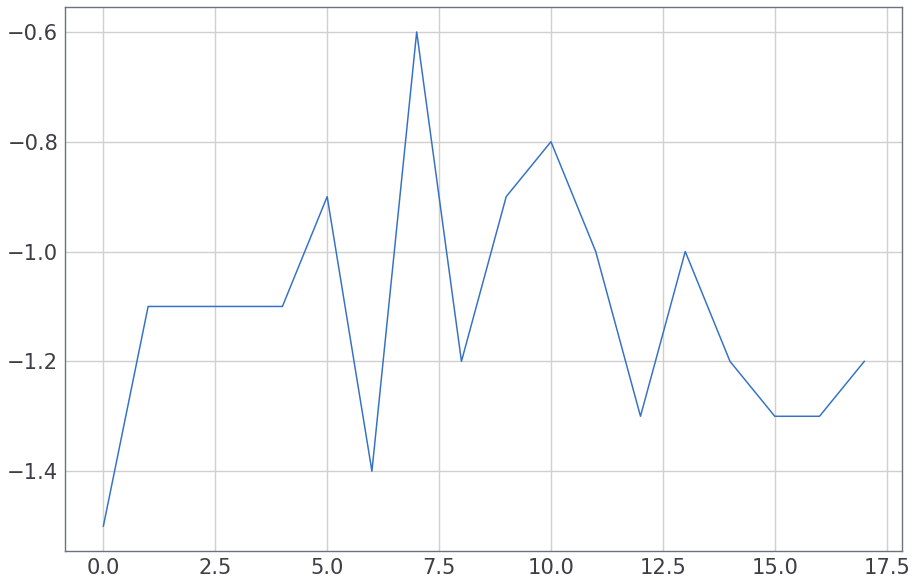

In [54]:
plot(groupmean(total_rewards, 10))

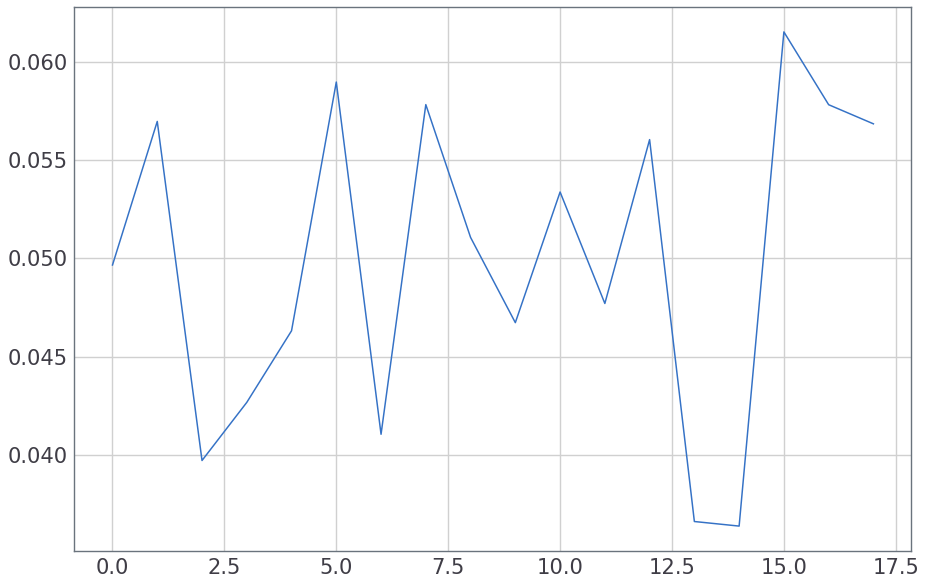

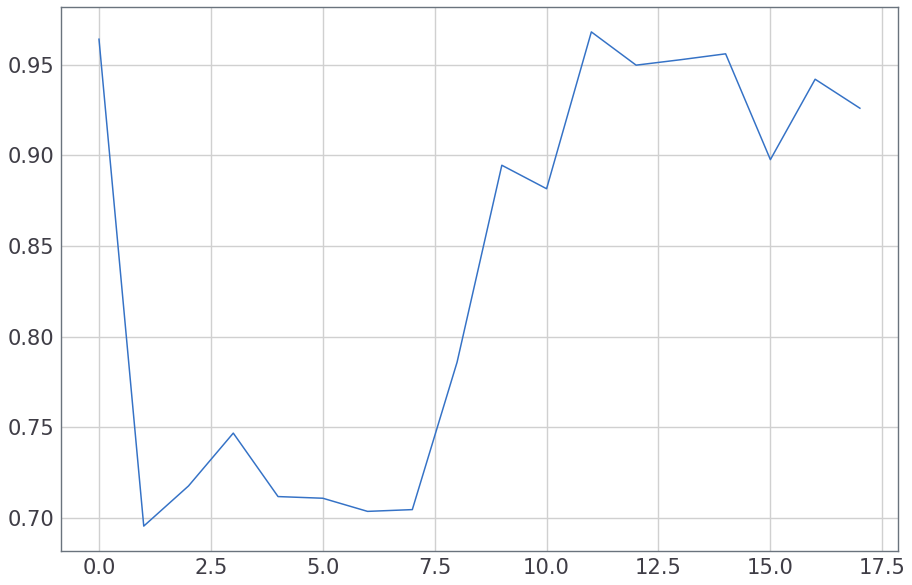

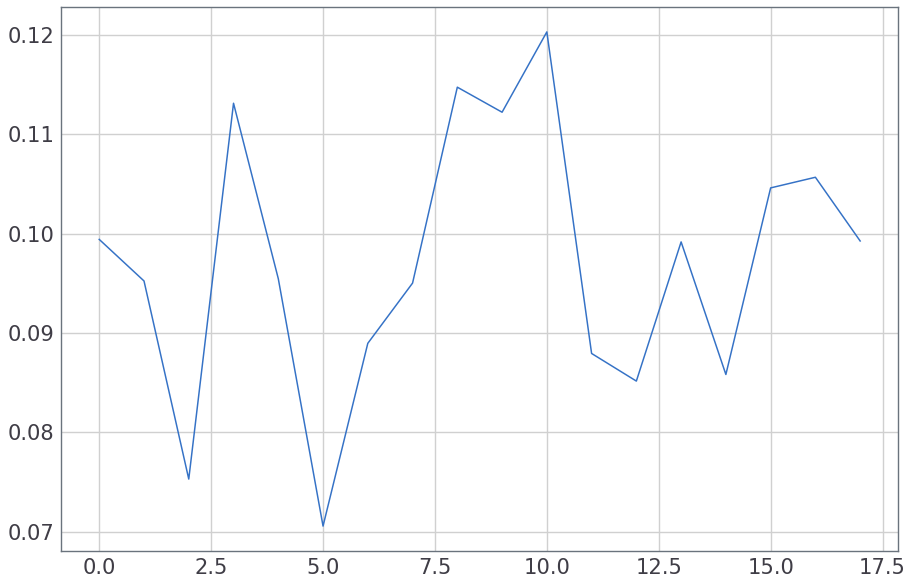

In [55]:
plot(groupmean(np.abs(actor_losses), 10)); plt.show()
plot(groupmean(np.abs(entropy_losses), 10)); plt.show()
plot(groupmean(critic_losses, 10)); plt.show()

In [56]:
test_one_episode(10000, probabilistic=False)

-21.0

In [57]:
test_one_episode(10000, probabilistic=True)

-18.0

In [59]:
for episode in range(1):
    state = normalize(env.reset())
    done = False
    r = 0

    for step in range(500):
        env.render()
        action = actor.act(state, probabilistic=True).item()
        with torch.no_grad():
            a = actor(torch.tensor(state, device=device)).cpu().numpy()
            print('Actor', a)
            print('Critic', critic(torch.tensor(state, device=device)).squeeze().item())
        state, reward, done, _ = env.step(rom_action(action))
        state = normalize(state)
        r += reward
        
        sleep(0.01)
        if done: break

    env.close()
    print(r)

Actor [-0.49845716  5.2188573   7.897965  ]
Critic -0.7283014059066772
Actor [0.57927305 4.9262357  8.561446  ]
Critic -0.7257153987884521
Actor [0.8685385 5.3373113 8.658603 ]
Critic -0.7380443215370178
Actor [1.1067644 5.707686  8.715427 ]
Critic -0.7507697343826294
Actor [1.2782778 5.963234  8.7537365]
Critic -0.7621855139732361
Actor [1.3322219 6.0312514 8.772962 ]
Critic -0.7734586000442505
Actor [1.3666755 6.0692844 8.789214 ]
Critic -0.7845979332923889
Actor [1.1493436 6.507728  8.8181925]
Critic -0.81392902135849
Actor [1.4158403 6.1158    8.817838 ]
Critic -0.80625981092453
Actor [1.4403186 6.1389985 8.831745 ]
Critic -0.8167895674705505
Actor [1.4647456 6.1621776 8.845413 ]
Critic -0.8271216750144958
Actor [1.4891328 6.185348  8.858857 ]
Critic -0.8372634649276733
Actor [1.24684   6.5920634 8.8665495]
Critic -0.8647364377975464
Actor [1.1638964 6.455386  8.851948 ]
Critic -0.8731728792190552
Actor [1.4838345 6.1378865 8.87976  ]
Critic -0.8652230501174927
Actor [6.690321  6.7

Actor [6.594335  7.526427  6.5030675]
Critic -1.2582578659057617
Actor [6.0085735 6.714839  5.6508965]
Critic -1.2815412282943726
Actor [6.420616  7.3677154 6.433263 ]
Critic -1.279639482498169
Actor [6.488396  7.4953227 6.2591753]
Critic -1.3199247121810913
Actor [5.9811006 6.759336  5.652971 ]
Critic -1.340527057647705
Actor [4.596061  4.719269  4.6329784]
Critic -1.1546133756637573
Actor [5.034491  5.4923015 5.0478415]
Critic -1.17239248752594
Actor [5.570063  6.1332397 5.408875 ]
Critic -1.2220433950424194
Actor [5.71725   5.95288   5.5015764]
Critic -1.272557258605957
Actor [5.2244496 5.2501354 5.313498 ]
Critic -1.2862412929534912
Actor [5.4597907 5.767946  5.637956 ]
Critic -1.277462363243103
Actor [5.9750137 6.3768244 5.999093 ]
Critic -1.3226038217544556
Actor [6.423077  6.5427103 6.2383995]
Critic -1.4022496938705444
Actor [6.200359  6.178448  6.2170525]
Critic -1.4268802404403687
Actor [6.0385547 6.152397  6.6168513]
Critic -1.41983962059021
Actor [5.6553736 5.792573  6.2968

Actor [10.194251  9.858551  9.92898 ]
Critic -0.9383034706115723
Actor [8.728185 8.92655  9.450012]
Critic -0.9736496210098267
Actor [8.883173 9.176481 9.510559]
Critic -1.0085564851760864
Actor [9.135997 9.563219 9.443282]
Critic -1.0064666271209717
Actor [9.232479 9.869249 9.351245]
Critic -1.0026904344558716
Actor [9.023847 9.768465 9.24357 ]
Critic -0.9660059213638306
Actor [8.964196 9.781157 9.129268]
Critic -0.9643619060516357
Actor [8.736882 9.479019 8.764735]
Critic -0.9645130634307861
Actor [8.393281 9.139746 8.437985]
Critic -0.9620680809020996
Actor [8.147457 8.973572 8.424284]
Critic -0.951724648475647
Actor [7.7156997 8.513313  8.076262 ]
Critic -0.9330541491508484
Actor [7.2627406 7.9317303 7.479589 ]
Critic -0.9217728972434998
Actor [7.0220113 7.807954  7.288934 ]
Critic -0.9092673659324646
Actor [7.0065756 7.652922  6.5578923]
Critic -1.185510277748108
Actor [6.942688  7.6059594 6.5104337]
Critic -1.1874765157699585
Actor [7.188065  8.050725  6.9237275]
Critic -1.185381

Actor [7.8242803 8.488119  8.199978 ]
Critic -0.9431965351104736
Actor [6.9555573 8.335115  7.8498473]
Critic -0.9615613222122192
Actor [6.9198112 8.465389  7.5235777]
Critic -0.9696390628814697
Actor [6.8887076 8.671669  7.513226 ]
Critic -0.9733117818832397
Actor [7.7867913 8.770371  6.976608 ]
Critic -1.2494993209838867
Actor [7.7358212 8.722167  6.93013  ]
Critic -1.2472808361053467
Actor [8.036073  9.137337  7.4872813]
Critic -1.2453583478927612
Actor [7.8597875 8.964392  7.332558 ]
Critic -1.2396632432937622
Actor [7.0534325 7.860811  6.5120153]
Critic -1.2310824394226074
Actor [6.759096  7.6495547 6.1423793]
Critic -1.2263916730880737
Actor [7.093982  8.087861  6.8495784]
Critic -1.2302900552749634
Actor [6.8459163 7.7803383 6.7058578]
Critic -1.227170467376709
Actor [6.436349 7.135106 6.122186]
Critic -1.2460098266601562
Actor [6.3670297 7.075113  6.0679293]
Critic -1.2565412521362305
Actor [6.601126  7.5515327 6.5580564]
Critic -1.2536195516586304
Actor [6.5321684 7.4924326 6.